In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
import pandas as pd


In [3]:
# SHARED
_k_b = scipy.constants.k
_rho = 4200
_rho_f = 790

_r =  1.3684204359439797e-06
_gain = np.sqrt(537680100419411.0)
_K = 8.046462556775461e-05

_m = 4/3 *np.pi *_r**3*_rho + 2/3 *np.pi *_r**3*_rho_f
_temp = 293
_viscous = 0.32e-3
_v_force = 6*np.pi*_r*_viscous

bin_number_data = 30
timestep_data = bin_number_data/200000000

print(timestep_data)
print("momentum relation time is " + str(_m/_v_force))


1.5e-07
momentum relation time is 5.3099070775713524e-06


In [4]:
# Calculate the average MSD
def compute_msd(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(n) * dt  # Calculate lag times

    for tau in tqdm(range(n)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)

    return msd, lag_times

# Calculate the zero init MSD

def compute_init_msd(sequence):
    MS = np.zeros(len(sequence))
    for i in range(1, len(MS)):
        MS[i] = (sequence[0] - sequence[i])**2
        #print(np.abs(sequence[0] - sequence[1]) / np.abs(sequence[50] - sequence[55]))
    return MS

def compute_init_msd2(time_trace, dt):

    n = len(time_trace)
    lag_times = np.arange(n) * dt  # Calculate lag times

    msd_ = [(time_trace[k]-time_trace[0])**2 for k in range(n)]
    return msd_, lag_times


In [5]:
# ANALYTICAL FUNCTIONS

# GENERAL WHITE NOISE
def msd_wn(t):
    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    return (2*_k_b*_temp/_K)*(1-np.exp(-t/(2*tau))*(np.cosh(omega_1*t)+(1/(2*omega_1*tau))*np.sinh(omega_1*t)))

# INITIALLY ZERO WHITE NOISE
def just_noise(t):

    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
    denominator = -2 + 8*tau**2*omega_1**2#-1*8*tau**2*omega_0**2
    final_scale = 12*np.pi*_r*_viscous*_k_b*_temp / _m**2 / omega_1**2
    return (numerator / denominator) * final_scale

# INITIAL SET VARIANCE WHITE NOISE
def known_initial_v_0(t, tol_percent):

    tau = _m / _v_force

    #Defines important auxillary variables

    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    T = omega_1*t

    #Gets contribution from the thermal white noise
    gamma = just_noise(t)

    #Gets contribution from initial position variation
    # hyp_factors = np.exp(-1*t/tau)*(np.cosh(T)**2 + 1/(4*(omega_1*tau)**2)*np.sinh(T)**2 + 1/(omega_1*tau)*np.cosh(T)*np.sinh(T)) - np.exp(-1*t/(2*tau))*(2*np.cosh(T) - 1/(2*omega_1*tau)*np.sinh(T))
    hyp_factors = (1 - np.exp(-t/(2*tau))*(np.cosh(omega_1*t) + np.sinh(omega_1*t)/(2*omega_1*tau)))**2

    #alpha easier to type than tol_percent
    alpha = tol_percent

    #Gets the second moment of the velocity assuming a probabiity distribution of
    #a Gaussian cut off on its wings by some fraction of its standard deviation (alpha/tol_percent)
    updated_sigma = 1 - alpha*np.exp(-alpha**2/2)*np.sqrt(2/np.pi)/scipy.special.erf(alpha/np.sqrt(2))

    #Calculates the contribution from the intitial velocity spread
    velo = np.exp(-1*t/tau) / omega_1**2 * np.sinh(omega_1*t)**2 *_k_b*_temp / _m * updated_sigma

    #Puts the pieces together
    return _k_b*_temp / _K * ( hyp_factors) + gamma + velo

# HYDRODYNAMIC GENERAL CASE
def hydro_msd(t):
    trap_const = _K
    use_mass = _m
    m_f = 2 / 3 * np.pi * _r ** 3 * 1000
    t_k = (6 * np.pi * _r * _viscous) / _K
    t_f = (_rho_f * _r ** 2) / _viscous
    t_p = _m / (6 * np.pi * _r * _viscous)
    print("tp is " + str(t_p))
    print(t_f)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a_ = t_p
    b = -1 * np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a_, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    # I need to learn how to vectorize my code better
    term_1 = scipy.special.erfcx(roots[0] * np.sqrt(t)) / (
                roots[0] * (roots[0] - roots[1]) * (roots[0] - roots[2]) * (roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1] * np.sqrt(t)) / (
                roots[1] * (roots[1] - roots[0]) * (roots[1] - roots[2]) * (roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2] * np.sqrt(t)) / (
                roots[2] * (roots[2] - roots[1]) * (roots[2] - roots[0]) * (roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3] * np.sqrt(t)) / (
                roots[3] * (roots[3] - roots[1]) * (roots[3] - roots[2]) * (roots[3] - roots[0]))

    D = _k_b * _temp / (6 * np.pi * _viscous * _r)
    # Returns theoretical MSD
    return np.real(2 * _k_b * _temp / trap_const + 2 * _k_b * _temp / (use_mass) * (
                term_1 + term_2 + term_3 + term_4))



In [6]:
# DATA

chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks1 = []

for chunk in pd.read_csv(rf'C:\Users\mct2723\Desktop\Repos\Brownian_Data_Analysis\for_publishing\data\barium_titanate_in_acetone_position_bin{bin_number_data}.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks1.append(chunk)

data_df_pos_data = pd.concat(chunks1, ignore_index=True)

chunks2 = []

for chunk in pd.read_csv(rf'C:\Users\mct2723\Desktop\Repos\Brownian_Data_Analysis\for_publishing\data\barium_titanate_in_acetone_velocity_bin{bin_number_data}.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks2.append(chunk)

data_df_vel_data = pd.concat(chunks2, ignore_index=True)

# Convert DataFrame into a numpy array where each column is an entry
traces_data = data_df_pos_data.to_numpy().T  # transpose if you want each col as an entry

# Convert DataFrame into a numpy array where each column is an entry
v_traces_data = data_df_vel_data.to_numpy().T  # transpose if you want each col as an entry


# GET THE EQ MSD
all_msd_data = []
lag_times_data = 0
for series in traces_data:
    msd, lag_times_data = compute_msd(series, timestep_data)
    all_msd_data.append(msd)

eq_msd_data = np.mean(all_msd_data, axis=0)


100%|██████████| 559240/559240 [06:49<00:00, 1365.23it/s] 


In [7]:
# Error bar calculation
import numpy as np
from scipy.optimize import brentq
import numpy as np
from scipy.optimize import brentq

def estimate_corrected_error2(data):
    x = np.array(data, dtype=np.float64)

    # Normalize to avoid floating point underflow
    scale = np.max(np.abs(x))
    if scale == 0:
        return {
            "mean": 0.0,
            "std_dev": 0.0,
            "correlation_factor_f": 0.0,
            "corrected_error_bar": 0.0
        }
    x_scaled = x / scale

    N = len(x_scaled)
    mean = np.mean(x_scaled)
    s2 = np.var(x_scaled, ddof=1)
    if s2 == 0:
        return {
            "mean": mean * scale,
            "std_dev": 0.0,
            "correlation_factor_f": 0.0,
            "corrected_error_bar": 0.0
        }

    s = np.sqrt(s2)
    x_centered = x_scaled - mean
    numerator = np.sum(x_centered ** 2)
    sum_xc = np.sum(x_centered)

    def chi_squared(f):
        if not (0 < f < 1):
            return np.inf

        try:
            denominator = 1 - f
            correction = f / (1 + f * (N - 1))
            total = (numerator / s2 - correction * (sum_xc ** 2) / s2) / denominator
            if not np.isfinite(total):
                return np.inf
            return total - (N - 1)
        except Exception:
            return np.inf

    # Try to solve for f, with fallback if it fails
    try:
        f_opt = brentq(chi_squared, 1e-4, 0.999)
    except ValueError:
        f_opt = 0.0  # fallback: assume no correlation

    sigma_corrected = s * np.sqrt((1 + f_opt * (N - 1)) / N)

    # Rescale outputs
    return {
        "mean": mean * scale,
        "std_dev": s * scale,
        "correlation_factor_f": f_opt,
        "corrected_error_bar": sigma_corrected * scale
    }

def estimate_corrected_error(data):

    x = np.array(data)
    N = len(x)
    mean = np.mean(x)
    s2 = np.var(x, ddof=1)
    s = np.sqrt(s2)
    x_centered = x - mean

    # Function to solve: Schmelling's chi^2(f) = N - 1
    def chi_squared(f):
        numerator = np.sum(x_centered ** 2)
        denominator = 1 - f
        correction = f / (1 + f * (N - 1))
        total = (numerator / s2 - correction * (np.sum(x_centered) ** 2) / s2) / denominator
        return total - (N - 1)

    # Solve for f in a safe range [0, 0.999] to avoid singular matrix
    f_opt = brentq(chi_squared, 1e-2, 0.999)

    # Corrected standard error of the mean
    sigma_corrected = s * np.sqrt((1 + f_opt * (N - 1)) / N)

    return {
        "mean": mean,
        "std_dev": s,
        "correlation_factor_f": f_opt,
        "corrected_error_bar": sigma_corrected
    }


In [8]:
import math
from scipy import constants

def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots = compute_roots(_m, _K, _r, _viscous, _rho_f)

def a_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/_m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/_m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def s_minus_half_b_inverse_form(t, roots):
     return np.real((-1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def experfc_inverse_form(t, tau, roots):
    return np.real((1/_m) * sum(
        (z * ((1/np.sqrt(np.pi*(t-tau)))-(z*np.exp(z**2*(t-tau))*scipy.special.erfc(z*np.sqrt(t-tau))))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((constants.k*_temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, mass, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) #+ z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)
#
def stat_hydro_msd(t, roots):
    return 2*constants.k*_temp*c_inverse_form(t, roots)

def v_t1_v_t2(t1, t2, m, K):
    return _k_b*_temp*(a_inverse_form(np.abs(t2-t1), roots) - m*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) - K*b_inverse_form(t1, roots)*b_inverse_form(t2, roots))



In [9]:
# LOOK FOR SPECIFIC SPEEDS

speeds = [0, .5, 1, 2]
traces_per_speed = [0, 0, 0, 0]

data_speeds_msds = []
error_bar_speeds= []

speed_tol = [.01, .01, .01, .01]
lag_times_speed_data = 0

for s in range(len(speeds)):

    all_speeds_msd_data = []

    init_len_data = int(len(traces_data[0])/10)

    for i in range(len(traces_data)):
        speed_idxs_data = []
        print("std of data vel " + str(np.std(v_traces_data[i])))
        print("kb*T*gain = " + str(_gain*np.sqrt(_k_b*_temp/_m)))

        v_tolerance = (speeds[s] * np.std(v_traces_data[i]))
        speed_tolerance = speed_tol[s] * np.std(v_traces_data[i])
        v_indices_data = np.where((v_traces_data[i] < v_tolerance + speed_tolerance) & (v_traces_data[i] > v_tolerance - speed_tolerance))[0]

        for idx in v_indices_data:
            if idx + init_len_data < len(traces_data[i]):
                speed_idxs_data.append(idx)

        print("total idx data: " + str(len(speed_idxs_data)))
        traces_per_speed[s] += len(speed_idxs_data)
        for idx in speed_idxs_data:
            msd, lag_times_speed_data = compute_init_msd2(traces_data[i][idx:idx+init_len_data], timestep_data)
            all_speeds_msd_data.append(msd)

    print(f"-------TOTAL TRACES DATA {traces_per_speed[s]}------------")

    # Calculate error bar for each lag time at this speed
    # print(f"SHAPE {np.array(all_speeds_msd_data).shape}")
    all_speeds_msd_data_array = np.array(all_speeds_msd_data)

    all_lag_data_groups = all_speeds_msd_data_array.T

    error_bars_for_speed = []
    for lag in all_lag_data_groups:
        dict = estimate_corrected_error2(lag)
        error_bars_for_speed.append(dict["corrected_error_bar"])
    speed_msd_data = np.mean(all_speeds_msd_data_array, axis=0)

    data_speeds_msds.append(speed_msd_data)
    error_bar_speeds.append(error_bars_for_speed)


std of data vel 6515.0796925188715
kb*T*gain = 6641.283924201093
total idx data: 4088
std of data vel 6514.327269830018
kb*T*gain = 6641.283924201093
total idx data: 3924
std of data vel 6567.631570697113
kb*T*gain = 6641.283924201093
total idx data: 4049
std of data vel 6501.203287693225
kb*T*gain = 6641.283924201093
total idx data: 4013
std of data vel 6562.984236686738
kb*T*gain = 6641.283924201093
total idx data: 4060
-------TOTAL TRACES DATA 20134------------
std of data vel 6515.0796925188715
kb*T*gain = 6641.283924201093
total idx data: 3584
std of data vel 6514.327269830018
kb*T*gain = 6641.283924201093
total idx data: 3500
std of data vel 6567.631570697113
kb*T*gain = 6641.283924201093
total idx data: 3441
std of data vel 6501.203287693225
kb*T*gain = 6641.283924201093
total idx data: 3593
std of data vel 6562.984236686738
kb*T*gain = 6641.283924201093
total idx data: 3510
-------TOTAL TRACES DATA 17628------------
std of data vel 6515.0796925188715
kb*T*gain = 6641.2839242010

In [10]:
times_analytic = np.logspace(np.log10(lag_times_data[1]), np.log10(lag_times_data[-1]), 200)

mu = 0
# sigma_v = np.sqrt(_k_b*_temp/_m)
sigma_x = np.sqrt(_k_b*_temp/_K)

num_samples = 10000

# initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)

results_speed = np.zeros((num_samples, len(times_analytic)))
results_speed_no_half = np.zeros((num_samples, len(times_analytic)))
results = np.zeros((num_samples, len(times_analytic)))

speeds_analytic_no_half = []
for speed in speeds:
    print("Speed X")
    for i in range(num_samples):
        results_speed_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], speed* np.sqrt(_k_b*_temp/_m))
    speeds_analytic_no_half.append(results_speed_no_half.mean(axis=0))
    results_speed_no_half = np.zeros((num_samples, len(times_analytic)))


Speed X
Speed X
Speed X
Speed X


tp is 5.3099070775713524e-06
4.103346409602152e-06


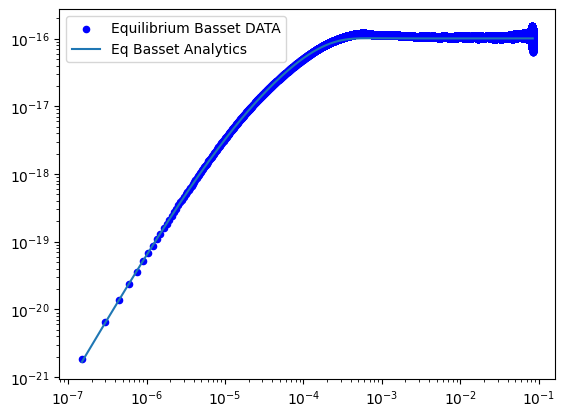

C:\Users\mct2723\AppData\Local\Temp\ipykernel_28044\1809820822.py:16: RuntimeWarning: overflow encountered in exp
  numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
C:\Users\mct2723\AppData\Local\Temp\ipykernel_28044\1809820822.py:16: RuntimeWarning: overflow encountered in cosh
  numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
C:\Users\mct2723\AppData\Local\Temp\ipykernel_28044\1809820822.py:16: RuntimeWarning: invalid value encountered in add
  numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
C:\Users\mct2723\AppData\Local\Temp\ipykernel_28044\1809820822.py:16: RuntimeWarning: overflow encountered in sinh
  numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*ome

tp is 5.3099070775713524e-06
4.103346409602152e-06


<Figure size 1000x1000 with 0 Axes>

C:\Users\mct2723\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


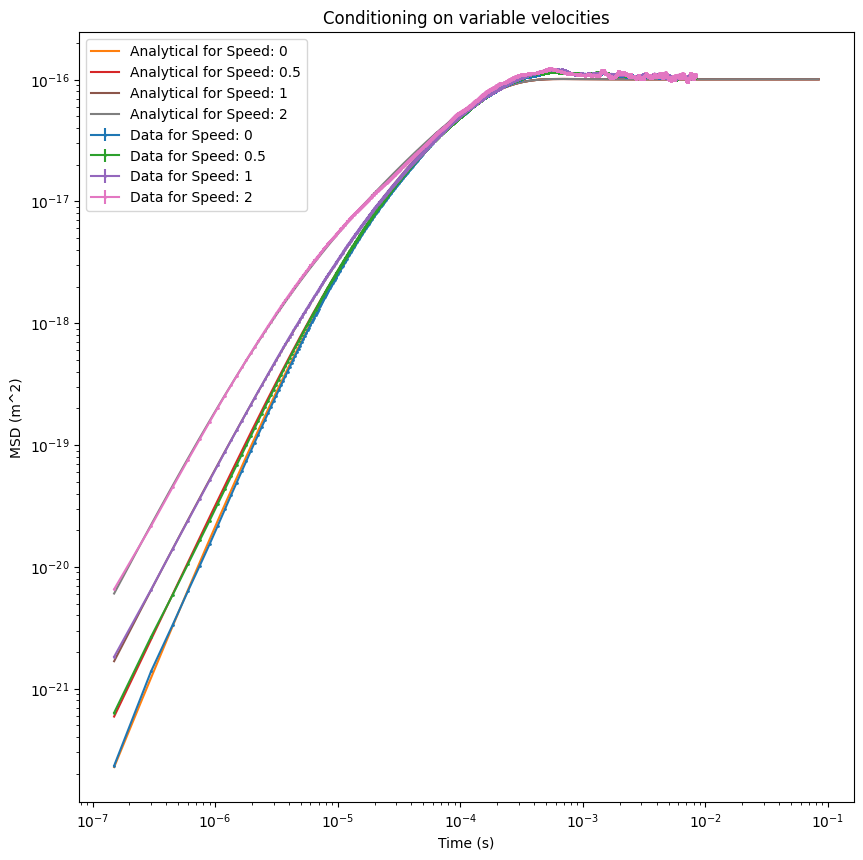

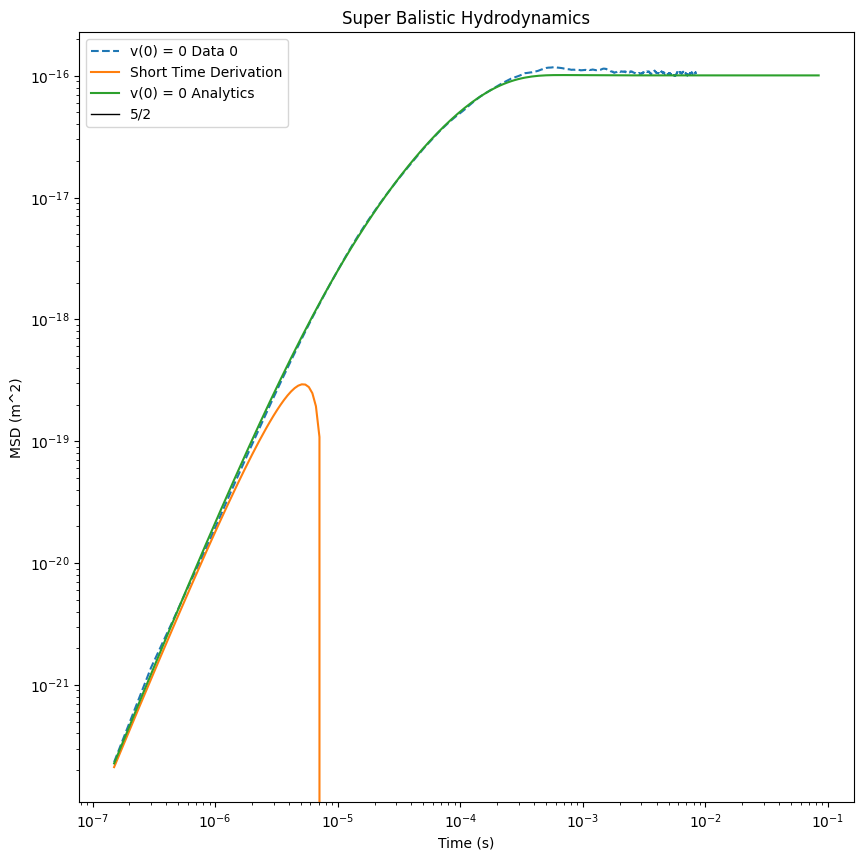

In [11]:
# GRAPHING
basset_msd = hydro_msd(times_analytic)
# DATA GRAPHING
plt.scatter(lag_times_data[1:], eq_msd_data[1:]/_gain**2,s=20, label="Equilibrium Basset DATA", color = "blue")
plt.plot(times_analytic, basset_msd, label= "Eq Basset Analytics")
with open('save_out_for_figures/eq_data.dat', 'w') as f:
    f.write(f"# EQ DATA \n")
    data = np.column_stack((lag_times_data[1:], eq_msd_data[1:]/_gain**2))
    np.savetxt(f, data, fmt='%.15e')
with open('save_out_for_figures/eq_analytic.dat', 'w') as f:
    f.write(f"# EQ Analytic \n")
    data = np.column_stack((times_analytic, basset_msd))
    np.savetxt(f, data, fmt='%.15e')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))

#  Set times for analytic functions

init_zero_WN_analytic = just_noise(times_analytic)
analytic_tol_msds = []

WN_EQ_analytic = msd_wn(times_analytic)
basset_msd = hydro_msd(times_analytic)

# laplace_form = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, np.sqrt(_k_b*_temp/_K), 0, roots, _temp)
# laplace_form2 = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, np.sqrt(_k_b*_temp/_K), (.5 * np.average(np.abs((v_traces_data[0]))))/_gain, roots, _temp)
# stationairy1 = full_hydro_msd(1000, 1000+times_analytic, _m, _K, _r, _viscous, _rho_f, np.sqrt(_k_b*_temp/_K), np.sqrt(_k_b*_temp/_m), roots, _temp)
# stationairy2 = full_hydro_msd(1000, 1000+times_analytic, _m, _K, _r, _viscous, _rho_f, 0,0, roots, _temp)

def form_func(times):
    return (2/3)*(12/5)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(5/2)*(_k_b*_temp/(_m**2/_v_force)) - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)
def graph_5_2(times):
    return (4/3)*(12/5)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(5/2)*(_k_b*_temp/(_m**2/_v_force))# - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)
def graph_2(times):
    return (2/100)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(2)*(_k_b*_temp/(_m**2/_v_force))# - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)
def graph_3(times):
    return (1000)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(3)*(_k_b*_temp/(_m**2/_v_force))# - 2/3

def graph_2(times):
    return (np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(2)*(_k_b*_temp/(_m**2/_v_force))/550

plt.figure(figsize=(10,10))

# SPEEDS
for i in range(0, len(speeds)):
    plt.errorbar(lag_times_speed_data[1:], data_speeds_msds[i][1:]/_gain**2, yerr = error_bar_speeds[i][1:]/_gain**2, marker='o', markersize=1, label=f"Data for Speed: {speeds[i]}")
    plt.plot(times_analytic, speeds_analytic_no_half[i], label=f"Analytical for Speed: {speeds[i]}")

plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")
plt.title("Conditioning on variable velocities")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# ZERO PLOT
plt.figure(figsize=(10,10))
plt.plot(lag_times_speed_data[1:], data_speeds_msds[0][1:]/_gain**2, linestyle = 'dashed', label=f"v(0) = 0 Data {speeds[0]}")
plt.plot(times_analytic, form_func(times_analytic), label= "Short Time Derivation")
plt.plot(times_analytic, speeds_analytic_no_half[0], label=f"v(0) = 0 Analytics")
plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_5_2(np.array(times_analytic[30:int(len(times_analytic)/7)])), label="5/2", color='black', linewidth=1)
plt.title("Super Balistic Hydrodynamics")
plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")

with open('save_out_for_figures/data_speeds.dat', 'w') as f:
    for i in range(len(speeds)):
        f.write(f"# Traces used {traces_per_speed[i]} | Speed {speeds[i]}\n")
        data = np.column_stack((lag_times_speed_data[1:], data_speeds_msds[i][1:] / _gain**2))
        np.savetxt(f, data, fmt='%.15e')

with open('save_out_for_figures/analytic_speeds.dat', 'w') as f:
    for i in range(len(speeds)):
        f.write(f"# Speed {speeds[i]}\n")
        data = np.column_stack((times_analytic, speeds_analytic_no_half[i]))
        np.savetxt(f, data, fmt='%.15e')

with open('save_out_for_figures/data_error_bars.dat', 'w') as f:
    for i in range(len(speeds)):
        f.write(f"# Traces used {traces_per_speed[i]} | Speed {speeds[i]}\n")
        data = np.column_stack((lag_times_speed_data[1:], error_bar_speeds[i][1:]/_gain**2))
        np.savetxt(f, data, fmt='%.15e')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


In [12]:
# Trace length in time
# Number of points per trace
print("number of binned points per trace "+str(len(traces_data[0])))
print("length of trace (s) " + str(len(traces_data[0])*timestep_data))


number of binned points per trace 559240
length of trace (s) 0.083886


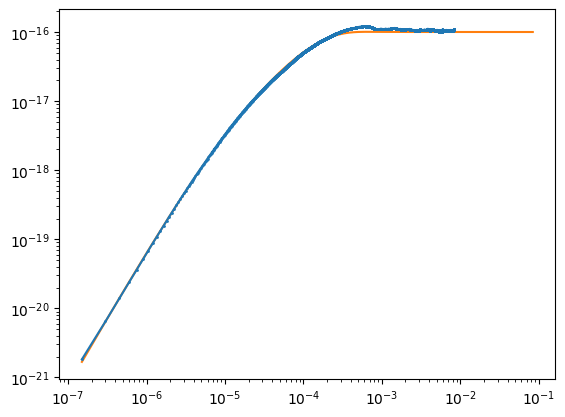

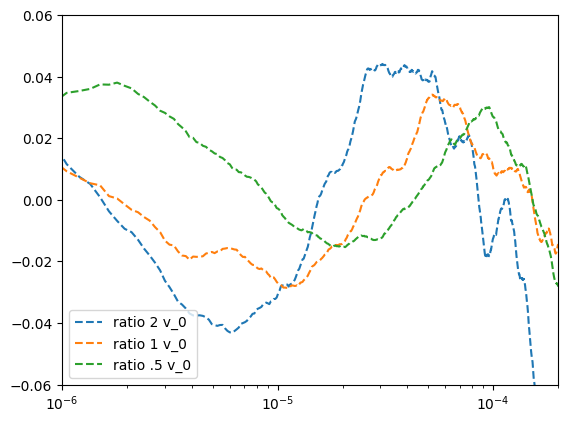

In [26]:
plt.errorbar(lag_times_speed_data[1:], data_speeds_msds[2][1:]/_gain**2, yerr = error_bar_speeds[2][1:]/_gain**2, marker='o', markersize=1, label=f"Data for Speed: {speeds[2]}")
plt.plot(times_analytic, speeds_analytic_no_half[2], label=f"Analytical for Speed: {speeds[2]}")
plt.xscale("log")
plt.yscale('log')
plt.show()

from scipy.interpolate import interp1d

intrp = interp1d(times_analytic, speeds_analytic_no_half[3], fill_value='extrapolate')
analytic_2 = intrp(lag_times_speed_data[1:])


intrp = interp1d(times_analytic, speeds_analytic_no_half[1], fill_value='extrapolate')
analytic_55 = intrp(lag_times_speed_data[1:])


intrp = interp1d(times_analytic, speeds_analytic_no_half[2], fill_value='extrapolate')
analytic_1 = intrp(lag_times_speed_data[1:])

# plt.plot(lag_times_speed_data[1:], (analytic_2 - data_speeds_msds[3][1:]/_gain**2)/analytic_2, linestyle='dashed', label="ratio 2 v_0")
# plt.plot(lag_times_speed_data[1:], (analytic_1 - data_speeds_msds[2][1:]/_gain**2)/analytic_1, linestyle='dashed', label="ratio 1 v_0")
plt.plot(lag_times_speed_data[1:], (analytic_55 - data_speeds_msds[1][1:]/_gain**2)/analytic_1, linestyle='dashed', label="ratio .5 v_0")
plt.xscale('log')
plt.xlim(left=1e-6, right=2e-4)
plt.ylim(bottom=-.06, top=.06)
plt.legend()
plt.show()